In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# Simulated sensor data (temperature, weight, distance, voltage, sound, vibration)
data = pd.read_csv("machinery_data.csv")  # Load real sensor data here

# Normalize the data (scale values between 0 and 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split into training and testing (use only normal data for training)
train_data = data_scaled[:5000]  # Assume first 5000 entries are normal
test_data = data_scaled[5000:]   # Later data may have anomalies

print(data.head())

   sensor_1  sensor_2  sensor_3  operational_hours  maintenance          RUL
0  0.496714  1.399355 -0.675178                831            0  4167.779109
1 -0.138264  0.924634 -0.144519               4061            0   937.137258
2  0.647689  0.059630 -0.792420               4801            0   197.222359
3  1.523030 -0.646937 -0.307962               2604            0  2393.654227
4 -0.234153  0.698223 -1.893615                714            0  4285.083772


In [3]:
# Simulate some sensor data (temperature, vibration, voltage, etc.)
np.random.seed(42)
num_features = 6  # Example: temperature, vibration, voltage, etc.
num_samples = 1000

# Generate normal operational data (values between 0-1 after scaling)
normal_data = np.random.normal(loc=0.5, scale=0.1, size=(num_samples, num_features))
anomalous_data = np.random.normal(loc=1.0, scale=0.2, size=(50, num_features))  # Simulated faults
# Combine normal and some anomalies to create a test set
test_data = np.vstack([normal_data[800:], anomalous_data])

# Split training & testing data
train_data = normal_data[:800]  # Train on normal behavior only
test_data = test_data  # Test set contains both normal & abnormal

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)  # Only transform test data
# Print shapes
print(f"Train Data Shape: {train_data_scaled.shape}")
print(f"Test Data Shape: {test_data_scaled.shape}")


 # ===================== 🔹 BUILD AUTOENCODER 🔹 =====================
input_dim = num_features

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")  # Output layer
])

Train Data Shape: (800, 6)
Test Data Shape: (250, 6)


In [4]:
 # ===================== 🔹 BUILD AUTOENCODER 🔹 =====================
input_dim = num_features

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")  # Output layer
])
autoencoder.compile(optimizer="adam", loss="mse")

# Train the autoencoder
history = autoencoder.fit(train_data_scaled, train_data_scaled, 
                          epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - val_loss: 0.0235
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0208
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - val_loss: 0.0187
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0169
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0148
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.0119
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Anomaly Threshold: 0.019075330978562486
🚨 Anomalies detected in 60 samples!


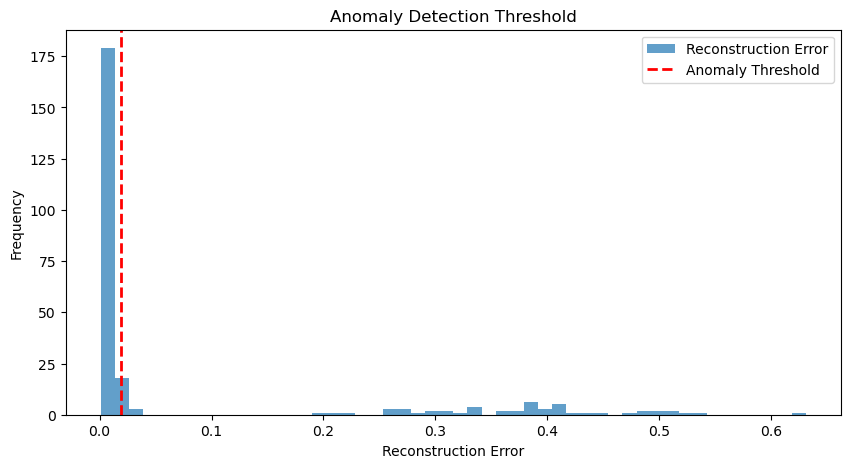

In [5]:
# Compute reconstruction errors for test data
reconstructed_data = autoencoder.predict(test_data_scaled)
reconstruction_errors = np.mean(np.abs(test_data_scaled - reconstructed_data), axis=1)



# Set an anomaly threshold (95th percentile of normal reconstruction errors)
threshold = np.percentile(reconstruction_errors[:200], 95)  # Use normal samples for threshold
print(f"Anomaly Threshold: {threshold}")
# Flag anomalies
anomalies = reconstruction_errors > threshold
print(f"🚨 Anomalies detected in {np.sum(anomalies)} samples!")



plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Anomaly Detection Threshold")
plt.show()


In [6]:

# ===================== 🔹 PRINT ANOMALY DATA 🔹 =====================
print("🚀 Anomalous Data Points:")
for i in range(len(anomalies)):
    if anomalies[i]:
        print(f"⚠ Anomaly {i+1}: {test_data[i]}")

🚀 Anomalous Data Points:
⚠ Anomaly 9: [0.44381579 0.5479361  0.23751829 0.75490097 0.55310261 0.51488768]
⚠ Anomaly 12: [0.51909165 0.49636694 0.51469353 0.44778684 0.80768604 0.63601159]
⚠ Anomaly 71: [0.6784775  0.50134504 0.47751469 0.40712079 0.79356579 0.3926672 ]
⚠ Anomaly 97: [0.75719953 0.27505675 0.56087356 0.44428694 0.44135849 0.43802279]
⚠ Anomaly 141: [0.57864062 0.44404537 0.21669697 0.63591895 0.57605061 0.32570525]
⚠ Anomaly 146: [0.74974151 0.50460064 0.43588857 0.78243306 0.36810315 0.50201065]
⚠ Anomaly 167: [0.80982994 0.47418249 0.55101244 0.43506352 0.52952326 0.47617663]
⚠ Anomaly 169: [0.77030276 0.47693383 0.61032176 0.64419424 0.52189639 0.41581784]
⚠ Anomaly 181: [0.25963314 0.63924559 0.56722934 0.34995235 0.35212229 0.66722659]
⚠ Anomaly 185: [0.4106254  0.4612035  0.48238665 0.21004861 0.66713476 0.40986243]
⚠ Anomaly 201: [0.77718373 0.87381383 0.81158796 0.89040084 0.95716994 1.1674309 ]
⚠ Anomaly 202: [0.93576819 0.68287486 1.22801357 0.83258197 0.98825